Importando os pacotes

In [1]:
import xarray as xr
from xskillscore import rmse

Importando os dados no formato `.nc` e atribuindo a variáveis

In [2]:
observation = xr.open_dataset('observation.nc')
forecast = xr.open_dataset('forecast.nc')
print(observation, forecast)

<xarray.Dataset>
Dimensions:      (time: 72, lon: 37, lat: 25)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00
  * lon          (lon) float32 -52.99 -52.75 -52.51 ... -44.74 -44.49 -44.25
  * lat          (lat) float32 -25.29 -25.07 -24.85 ... -20.37 -20.14 -19.92
Data variables:
    temperatura  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.1 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Apr 19 18:43:01 2018: cdo remapbil,gridfile observation...
    CDO:          Climate Data Operators version 1.9.1 (http://mpimet.mpg.de/... <xarray.Dataset>
Dimensions:  (lat: 25, lon: 37, time: 72)
Coordinates:
  * lat      (lat) float32 -25.29 -25.07 -24.85 -24.63 ... -20.37 -20.14 -19.92
  * lon      (lon) float32 -52.99 -52.75 -52.51 -52.26 ... -44.74 -44.49 -44.25
  * time     (time) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00
Data variables:
    t2m      (time, lat, lon) float3

Uniformizando as coordenadas e variáveis (forecast está com a variável 't2m')

In [3]:
forecast.coords['lat'] = observation['lat']
forecast.coords['lon'] = observation['lon']


observation = observation.rename_vars({'temperatura': 'observation'})
forecast = forecast.rename_vars({'t2m': 'forecast'})

Conversão de Kelvin para grau Celsius

In [4]:
forecast['forecast'] = forecast['forecast'] -273.15
forecast['forecast']

<xarray.DataArray 'forecast' (time: 72, lat: 25, lon: 37)>
array([[[24.72702 , 24.482635, 24.258118, ..., 26.03534 , 26.104248,
         26.150085],
        [24.592468, 24.593842, 24.700165, ..., 25.990814, 26.076508,
         26.155304],
        [24.957   , 24.85617 , 24.426025, ..., 25.94992 , 26.040527,
         26.102875],
        ...,
        [26.018494, 26.02945 , 25.839355, ..., 21.804688, 21.415619,
         21.299042],
        [25.895782, 26.101593, 25.808777, ..., 21.990753, 21.699188,
         21.418365],
        [25.934326, 25.436401, 25.435852, ..., 22.443665, 22.01062 ,
         21.970306]],

       [[24.315643, 23.957825, 23.681305, ..., 26.026886, 26.104858,
         26.14618 ],
        [24.302307, 24.21045 , 24.286346, ..., 26.037872, 26.120056,
         26.184113],
        [24.68515 , 24.572083, 24.124573, ..., 25.965149, 26.098877,
         26.154327],
...
        [24.102722, 23.789917, 23.46994 , ..., 18.383698, 17.723175,
         17.357178],
        [24.047241, 24.126709, 23.75061 , ..., 18.690277, 18.060028,
         17.527039],
        [24.448364, 23.793945, 23.749695, ..., 19.12851 , 18.538574,
         18.13858 ]],

       [[21.417358, 20.838074, 20.189575, ..., 24.136932, 24.209808,
         24.298859],
        [21.294006, 21.059967, 21.172302, ..., 24.289795, 24.372253,
         24.440857],
        [21.521515, 21.422394, 21.062592, ..., 24.391235, 24.45224 ,
         24.484192],
        ...,
        [23.697296, 23.43686 , 23.144562, ..., 17.854889, 17.275146,
         16.997498],
        [23.592743, 23.635895, 23.262085, ..., 18.098083, 17.549713,
         17.122437],
        [23.71939 , 23.193604, 23.289032, ..., 18.580963, 18.02658 ,
         17.68814 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -25.29 -25.07 -24.85 -24.63 ... -20.37 -20.14 -19.92
  * lon      (lon) float32 -52.99 -52.75 -52.51 -52.26 ... -44.74 -44.49 -44.25
  * time     (time) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00

Cálculo do índice RMSE para cada intervalo de 6 horas

In [5]:
df = xr.merge([observation, forecast])

rmse_6h = df.resample(time='6h').apply(lambda x: rmse(x['observation'], x['forecast'], dim='time')).rename('rmse')

rmse_6h.to_netcdf('RMSE_6hourly.nc', 'w')

Plotando série temporal

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

sns.set_style('darkgrid')

In [7]:
observation_6h_sp = observation.resample(time='6h').mean().sel(lat=-23.5489, lon=-46.6388, method='nearest')
observation_6h_sp

forecast_6h_sp = forecast.resample(time='6h').mean().sel(lat=-23.5489, lon=-46.6388, method='nearest')
forecast_6h_sp

rmse_6h_sp = rmse_6h.sel(lat=-23.5489, lon=-46.6388, method='nearest')
rmse_6h_sp = rmse_6h_sp.to_dataset()

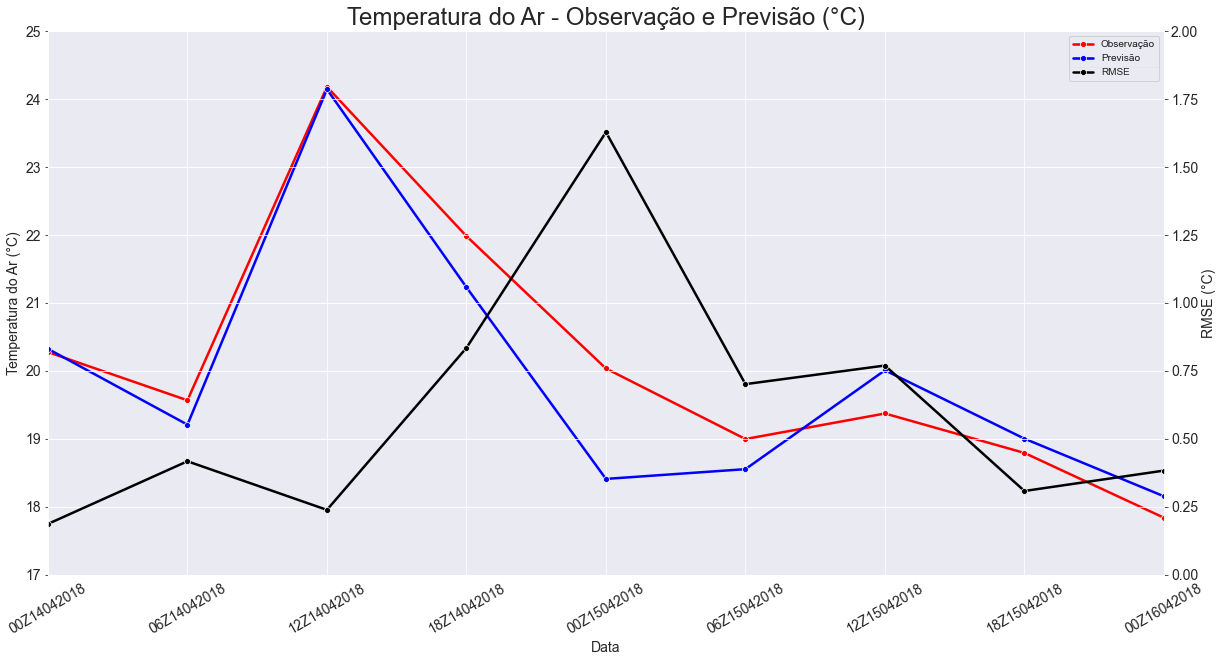

In [29]:
#plot da observação
axes_1 = sns.lineplot(x='time',
                  y='observation',
                  data=observation_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='red',
                  label='Observação')
#plot da previsão
axes_2 = sns.lineplot(x='time',
                  y='forecast',
                  data=forecast_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='blue',
                  label='Previsão')
#criação de um eixo secundário para o plot do RMSE
axes_3 = axes_1.twinx()

axes_3 = sns.lineplot(x='time',
                  y='rmse',
                  data=rmse_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='black',
                  label='RMSE')
#configurações do gráfico
axes_1.figure.set_size_inches(20, 10)

axes_1.set_title('Temperatura do Ar - Observação e Previsão (°C)', fontsize=24)

axes_1.set_xlabel('Data', fontsize=14)
axes_1.set_ylabel('Temperatura do Ar (°C)', fontsize=14)
axes_3.set_ylabel('RMSE (°C)', fontsize=14)

axes_1.tick_params(axis='x', rotation=30, labelsize=14)
axes_2.tick_params(labelsize=14)
axes_3.tick_params(labelsize=14)
axes_1.set_ylim([17,25])
axes_3.set_ylim([0,2])

datas = [datetime.date(2018, 4, 14), datetime.date(2018, 4, 16)]
plt.xlim([datas[0], datas[-1]])
axes_1.xaxis.set_major_formatter(mdates.DateFormatter('%HZ%d%m%Y'))

lines, labels = axes_1.get_legend_handles_labels()
lines2, labels2 = axes_3.get_legend_handles_labels()
axes_3.legend(lines + lines2, labels + labels2, loc=0)


plt.savefig("air_temp_sp.png", dpi=300)